<a href="https://colab.research.google.com/github/filipefborba/HandRecognition/blob/master/project3/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand Recognition
### Filipe F. Borba  
### Franklin W. Olin College of Engineering
### Data Science, Prof. Allen Downey


Machine Learning is very useful for a variety of real-life problems. It is commonly used for tasks such as classification, recognition, detection and predictions. Moreover, it is very efficient to automate processes that use data. The basic idea is to use data to produce a model capable of returning an output. This output may give a right answer with a new input or produce predictions towards the known data.

The goal of this project is to train a Machine Learning algorithm capable of classifying images of different hand gestures, such as a fist, palm, showing the thumb, and others. With this, I'll be able to understand more about this field and create my own program that fits the data that I have. This particular classification problem can be useful for [Gesture Navigation](https://www.youtube.com/watch?v=Lbma7c55wf8), for example. The method I'll be using is Deep Learning.

Deep Learning is part of a broader family of machine learning methods. It is based on the use of layers that process the input data, extracting features from them and producing a mathematical model. The creation of this said 'model' will be more clear in the next session. In this specific project, we'll be aiming to classify different images of hand gestures, which means that the computer will have to "learn" the features of each gesture and classify them correctly. For example, if it is given an image of a hand doing a thumbs up gesture, the output of the model needs to be "the hand is doing a thumbs up gesture".

Obs: This project was developed using the Google Colab environment.

In [1]:
# Here we import everything we need for the project

%matplotlib inline
#from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

1.13.1


## Loading Data

This project uses the [Hand Gesture Recognition Database](https://www.kaggle.com/gti-upm/leapgestrecog/version/1) (citation below) available on Kaggle. It contains 20000 images with different hands and hand gestures. There is a total of 10 hand gestures of 10 different people presented in the dataset. There are 5 female subjects and 5 male subjects.
The images were captured using the Leap Motion hand tracking device.

>Hand Gesture | Label used
>--- | ---
> Thumb down | 0
> Palm (Horizontal) | 1
> L | 2
> Fist (Horizontal) | 3
> Fist (Vertical) | 4
> Thumbs up | 5
> Index | 6
> OK | 7
> Palm (Vertical) | 8
> C | 9

Table 1 - Classification used for every hand gesture.


T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)  

Overview:
- Load images
- Some validation
- Preparing the images for training
- Use of train_test_split

In [2]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith(".png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

40000


In [3]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


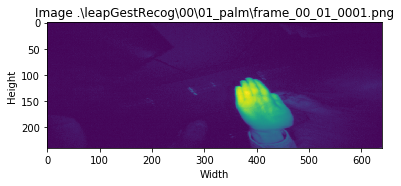

In [4]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

Now that we loaded the images and checked if it's everything we expected, we have to prepare the images to train the algorithm. We have to load all the images into an array that we will call **X** and all the labels into another array called **y**.

In [12]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  '''
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  '''
  
  # Processing label in image path
  a = path.split('\\')
  category = a[len(a)-1]
  #print(category)
  if len(category.split("_")) >= 3:
    # print(category.split("_")[2])
    try:
      label = int(category.split("_")[2]) # We need to convert 10_down to 00_down, or else it crashes
      y.append(label)
    except ValueError:
      print(path)
      #print(category)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)
print(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

ValueError: cannot reshape array of size 0 into shape (40000,120,320,1)

Scipy's train_test_split allows us to split our data into a training set and a test set. The training set will be used to build our model. Then, the test data will be used to check if our predictions are correct.  A random_state seed is used so the randomness of our results can be reproduced. The function will shuffle the images it's using to minimize training loss.


In [ ]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

## Creating Model

To simplify the idea of the model being constructed here, we're going to use the concept of Linear Regression. By using linear regression, we can create a simple model and represent it using the equation ```y = ax + b```.   
```a``` and ```b``` (slope and intercept, respectively) are the parameters that we're trying to find. By finding the best parameters, for any given value of x, we can predict y. This is the same idea here, but much more complex, with the use of Convolutional Neural Networks.

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

<img src="https://cdn-images-1.medium.com/max/1200/0*hzIQ5Fs-g8iBpVWq.jpg" alt="CNN Example" width="400">
Figure 1 - Example of Convolutional Neural Network.

From Figure 1 and imagining the Linear Regression model equation that we talked about, we can imagine that the input layer is x and the output layer is y. The hidden layers vary from model to model, but they are used to "learn" the parameters for our model. Each one has a different function, but they work towards getting the best "slope and intercept".


Overview:
- Import what the need
- Creation of CNN
- Compiling and training model
- Saving model for later use

In [ ]:
# Recreate the exact same model, including weights and optimizer.
# model = keras.models.load_model('handrecognition_model.h5')
# model.summary()

# To use the pre-trained model, just load it and skip to the next session.

In [ ]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

Convolutional neural networks (CNNs) are the current state-of-the-art model architecture for image classification tasks. CNNs apply a series of filters to the raw pixel data of an image to extract and learn higher-level features, which the model can then use for classification. CNNs contains three components:

- Convolutional layers, which apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.

- Pooling layers, which downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.

- Dense (fully connected) layers, which perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

https://www.tensorflow.org/tutorials/estimators/cnn

In [ ]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

Our Convolutional Neural Network consists of different layers that have different functions. As explained before, the Conv2D layer performs a 2-D convolutional operation, which can be basically interpreted as a mathematical operation to calculate weights inside the image. In order to maximize the network's performance, we need to understand the parameters required by them.

The first required by the Conv2D layer is the number of filters that the convolutional layer will learn. Layers early in the network architecture (closer to the actual input image) learn fewer convolutional filters while layers deeper in the network (closer to the output predictions) will learn more filters. This permits information to flow through the network without loss. These filters emulate edge detectors, blob detectors and other feature extraction methods.
It is necessary to tune the values of the filters, but it is common practice to use powers of 2, starting with 32, 64, 128 and increasing to 256, 512, 1024, for example.

<img src="https://www.researchgate.net/profile/Ihab_S_Mohamed/publication/324165524/figure/fig3/AS:611103423860736@1522709818959/An-example-of-convolution-operation-in-2D-2.png" alt="Example of 2D Convolution operation" width="500">

Figure 2 - Example of 2D convolution operation.

Another parameter required by the Conv2D layer is the kernel_size, a 2-tuple specifying the width and height of the 2D convolution window. The kernel_size must be an odd integer, with typical values of (1, 1) , (3, 3) , (5, 5) , (7, 7) . It’s rare to see kernel sizes larger than 7×7. If the input images are greater than 128×128 it is recommended to test a kernel size > 3 to help learn larger spatial filters and to help reduce volume size.

Then, MaxPooling2D is used to reduce the spatial dimensions of the output volume. It reduces processing time and allows assumptions to be made about features contained in the sub-regions binned. It is possible to notice in this network that our output spatial volume is decreasing and our number of filters learned is increasing. This is a common practice in designing CNN architectures.

Finally, ReLU stands for rectified linear unit, and is a type of activation function. ReLU is the most commonly used activation function in neural networks, especially in CNNs. ReLU is linear (identity) for all positive values, and zero for all negative values. This means that it's cheap to compute as there is no complicated math. The model can therefore take less time to train or run. Also, it converges faster by applying non-linearities to the model, so there is no 'vanishing gradient problem' suffered by other activation functions like sigmoid or tanh.

In the end, there is a lot of trial and error to get the best parameters and network architecture. These are some common practices that help reach the best result faster.

In [ ]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [ ]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

In [ ]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')

## Testing Model

Now that we have the model compiled and trained, we need to check if it's good. First, we run ```model.evaluate``` to test the accuracy. Then, we make predictions and plot the images as long with the predicted labels and true labels to check everything. With that, we can see how our algorithm is working.  
Later, we produce a confusion matrix, which is a specific table layout that allows visualization of the performance of an algorithm. 

Overview:
- Evaluate model
- Predictions
- Plot images with predictions
- Visualize model

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

In [ ]:
predictions = model.predict(X_test) # Make predictions towards the test set

In [ ]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

In [ ]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

In [ ]:
validate_9_images(predictions, y_test, X_test)

In [ ]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [ ]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

# Conclusion

Based on the results presented in the previous section, we can conclude that our algorithm successfully classifies different hand gestures images with enough confidence (>95%) based on a Deep Learning model.  

The accuracy of our model is directly influenced by a few aspects of our problem. The gestures presented are reasonably distinct, the images are clear and without background. Also, there is a reasonable quantity of images, which makes our model more robust. The drawback is that for different problems, we would probably need more data to stir the parameters of our model into a better direction. Moreover, a deep learning model is very hard to interpret, given it's abstractions.  
However, by using this approach it becomes much more easier to start working on the actual problem, since we don't have to account for feature engineering. This means that we don't need to pre-process the images with edge or blob detectors to extract the important features; the CNN does it for us. Also, it can be adapted to new problems relatively easily, with generally good performance.

As mentioned, another approach to this problem would be to use feature engineering, such as binary thresholding (check area of the hand), circle detection and others to detect unique characteristics on the images. However, with our CNN approach, we don't have to worry about any of these.

Any doubts? Feel free to send questions/issues on [the Github repository](https://github.com/filipefborba/HandRecognition)!